# テーマ：kickstarterが成功するか失敗するか分類したい

## １．データ項目の説明

初期状態について、ファンディング開始時に値が確定しているか未定化を表示

項目名　| 意味 | 初期状態 | 目的変数
-----------| ------------ | ------- | -----
ID | kickstarterのID | 確定 | 
name| プロジェクト名称| 確定 | 
category | カテゴリ | 確定 | 
main_category | キャンペーンのカテゴリ | 確定 | 
currency | 通貨 | 確定 | 
deadline | クラウドファンディングの締め切り | 確定 | 
goal | 目標額（currency） | 確定 | 
launched | 発売日 | 確定 | 
pledged | 誓約額（currency） | 未定 | 
state | 現在のプロジェクト状態 | 未定 | 〇
backers | 支援者の数 | 未定 | 
country | 国名（誓約） | 未定 | 
usd pledged | 誓約額（USD換算（KS)） | 未定 | 
usd_pledged_real | 誓約額（USD換算（fixer.io api)） | 未定 | 
usd_goal_real | 目標額（USD換算（fixer.io api)） | 確定 | 


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [15]:
##CSVファイルを読み込みdataframeに変換
df_kick = pd.read_csv("./ks-projects-201801.csv")[['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal','launched','pledged','state','backers','country','usd pledged','usd_pledged_real','usd_goal_real']]


In [16]:

#〇目的変数はstateとして実施する
#目的変数を１，０に変換する、stateにはsuccessfulとfailed以外がある
#######successfulとfailed以外を除外した場合にどうなるか検討が必要
#df_kick['state'] = df_kick['state'] == 'successful'

#〇説明変数の中で区分などを変換する
#そのままではなく、相関関係や切り口を変えたものが結果に影響するものを新規列として追加する
#・クラウドファンディングの締め切りから発売日までの日数
#・プロジェクト名称の文字数
#・・・・・・？
#通貨の分類をダミー変数として追加、USD、GBP、その他に圧縮
df_kick.loc[~(df_kick.currency == 'USD') & (~(df_kick.currency == 'GBP')), 'currency'] = 'other'
df_kick_dummy=pd.get_dummies(df_kick.currency)
df_kick = pd.concat([df_kick, df_kick_dummy], axis=1)

#deadlineからlaunchedを引いた日数を新しい列（term）を追加
def f_str(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')
df_kick.deadline = df_kick.deadline.map(f_str)
def f_str(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df_kick.launched = df_kick.launched.map(f_str)
df_kick["term"] = df_kick.deadline-df_kick.launched
def f_str(x):
    if x.days > 10000:
        return 0
    else:
        return x.days
df_kick["term_day"] = df_kick.term.map(f_str)

#プロジェクト名称の文字数で新しい列（name_len）を追加
def f_str(x):
    if type(x) is str:
        return len(x)
    else:
        return 0
df_kick["name_len"] = df_kick.name.map(f_str)

display(df_kick.head())

df_kick.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,country,usd pledged,usd_pledged_real,usd_goal_real,GBP,USD,other,term,term_day,name_len
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,GB,0.0,0.0,1533.95,1,0,0,58 days 11:47:32,58,31
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,US,100.0,2421.0,30000.00,0,1,0,59 days 19:16:03,59,45
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,US,220.0,220.0,45000.00,0,1,0,44 days 23:39:10,44,14
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,US,1.0,1.0,5000.00,0,1,0,29 days 20:35:49,29,49
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,...,US,1283.0,1283.0,19500.00,0,1,0,55 days 15:24:57,55,58


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,GBP,USD,other,term,term_day,name_len
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05,378661.000000,378661.000000,378661.000000,378661,378661.000000,378661.000000
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04,0.090139,0.780025,0.129836,33 days 21:58:10.533968,33.202807,34.834847
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06,0.286381,0.414230,0.336124,65 days 21:55:09.506515,12.793846,15.931822
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,0.000000,0.000000,0.000000,0 days 00:07:17,0.000000,0.000000
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03,0.000000,1.000000,0.000000,29 days 02:20:36,29.000000,21.000000
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03,0.000000,1.000000,0.000000,29 days 16:32:32,29.000000,34.000000
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04,0.000000,1.000000,0.000000,36 days 15:35:44,36.000000,49.000000
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08,1.000000,1.000000,1.000000,16738 days 23:00:00,91.000000,96.000000


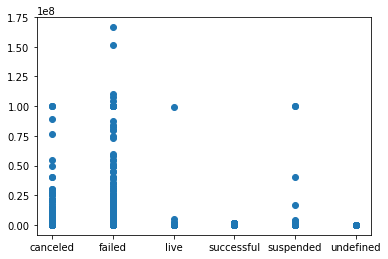

In [5]:
# 散布図を書いてみる 状況と目標額（USD換算（fixer.io api)）
plt.scatter(df_kick.state,df_kick.usd_goal_real)
plt.show()

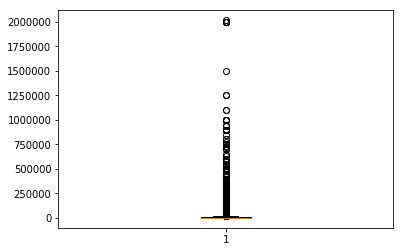

In [13]:
# 箱ひげ図を書いてみる 状況と目標額（USD換算（fixer.io api)）
plt.boxplot(df_kick[df_kick.state=="successful"].usd_goal_real)
plt.show()

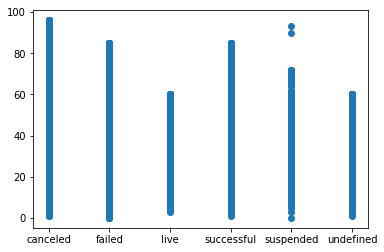

In [6]:
# 散布図を書いてみる 状況とプロジェクト名の文字数
plt.scatter(df_kick.state,df_kick.name_len)
plt.show()

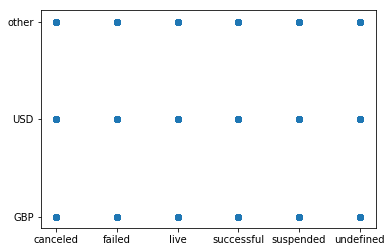

In [7]:
# 散布図を書いてみる 状況と通貨の文字数
plt.scatter(df_kick.state,df_kick.currency)
plt.show()

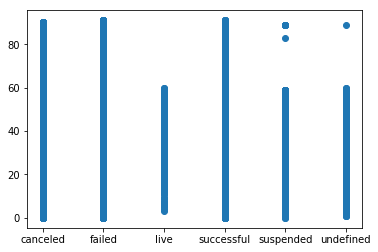

In [17]:
# 散布図を書いてみる 状況と発売日と期限日数
plt.scatter(df_kick.state,df_kick.term_day)
plt.show()

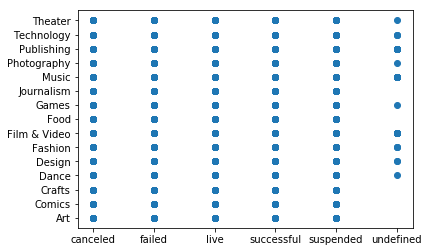

In [9]:
# 散布図を書いてみる 状況とカテゴリー
plt.scatter(df_kick.state,df_kick.main_category)
plt.show()

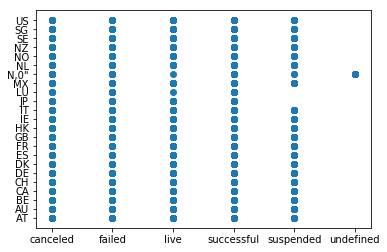

In [10]:
# 散布図を書いてみる 状況と国
plt.scatter(df_kick.state,df_kick.country)
plt.show()

In [11]:
#null値が入っている行を調査
df_kick.isnull().sum()/df_kick.shape[0]

ID                  0.000000
name                0.000011
category            0.000000
main_category       0.000000
currency            0.000000
deadline            0.000000
goal                0.000000
launched            0.000000
pledged             0.000000
state               0.000000
backers             0.000000
country             0.000000
usd pledged         0.010027
usd_pledged_real    0.000000
usd_goal_real       0.000000
GBP                 0.000000
USD                 0.000000
other               0.000000
term                0.000000
term_day            0.000000
name_len            0.000000
dtype: float64

In [45]:
#null値が入っている行を確認（name列にnull値が入っている場合に真）
df_kick[(df_kick['name'].isnull())]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,country,usd pledged,usd_pledged_real,usd_goal_real,GBP,USD,other,term,term_day,name_len
166851,1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.0,2012-01-01 12:35:31,100.0,failed,...,US,100.00,100.00,200000.00,0,1,0,58 days 11:24:29,58,0
307234,634871725,NaN,Video Games,Games,GBP,2013-01-06,2000.0,2012-12-19 23:57:48,196.0,failed,...,GB,317.73,316.05,3224.97,1,0,0,17 days 00:02:12,17,0
309991,648853978,NaN,Product Design,Design,USD,2016-07-18,2500.0,2016-06-18 05:01:47,0.0,suspended,...,US,0.00,0.00,2500.00,0,1,0,29 days 18:58:13,29,0
338931,796533179,NaN,Painting,Art,USD,2011-12-05,35000.0,2011-11-06 23:55:55,220.0,failed,...,US,220.00,220.00,35000.00,0,1,0,28 days 00:04:05,28,0


In [13]:
df_kick.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'GBP', 'USD',
       'other', 'term', 'term_day', 'name_len'],
      dtype='object')

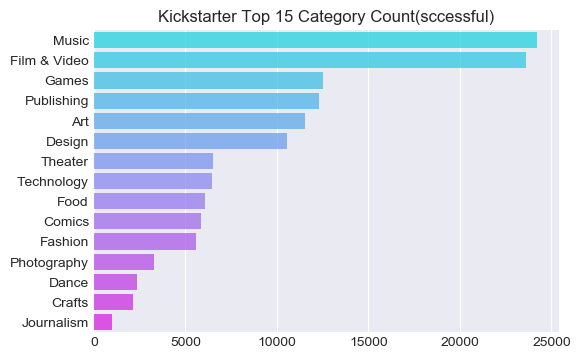

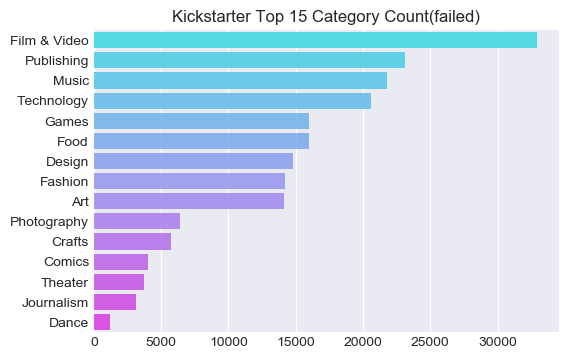

In [20]:
sns.set_style('darkgrid')

mains = df_kick[df_kick.state=='successful'].main_category.value_counts().head(15)

x_suc = mains.values
y_suc = mains.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y_suc, x=x_suc, orient='h', palette="cool", alpha=0.8)

plt.title('Kickstarter Top 15 Category Count(sccessful)')
plt.show()

mains = df_kick[(df_kick.state=='failed')&(df_kick.main_category.isin(y_suc))].main_category.value_counts().head(15)

x_fail = mains.values
y_fail = mains.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y_fail, x=x_fail, orient='h', palette="cool", alpha=0.8)

plt.title('Kickstarter Top 15 Category Count(failed)')
plt.show()


In [23]:
print(x_suc)
print(y_suc)

[24197 23623 12518 12300 11510 10550  6534  6434  6085  5842  5593  3305
  2338  2115  1012]
Index(['Music', 'Film & Video', 'Games', 'Publishing', 'Art', 'Design',
       'Theater', 'Technology', 'Food', 'Comics', 'Fashion', 'Photography',
       'Dance', 'Crafts', 'Journalism'],
      dtype='object')


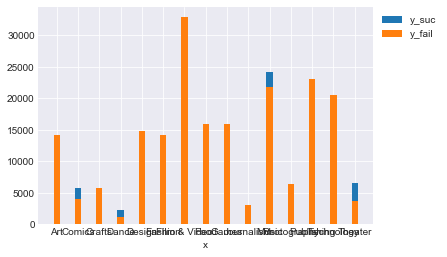

In [29]:
# 凡例
label1 = 'y_suc'
label2 = 'y_fail'
# グラフの間隔
width = 0.3

# 棒グラフの描画
plt.bar(x=y_suc, height=x_suc, width=width, label=label1)
plt.bar(x=y_fail, height=x_fail, width=width, label=label2)

# 軸を移動
#plt.xticks(x_suc + width/2, x_suc)

# x軸，y軸のラベルを設定
plt.xlabel('x')
#plt.ylabel('y')

# 凡例を表示
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

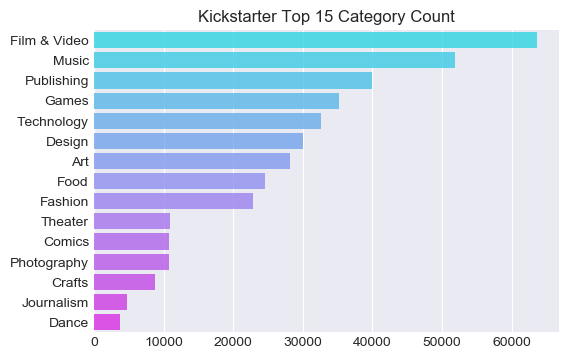

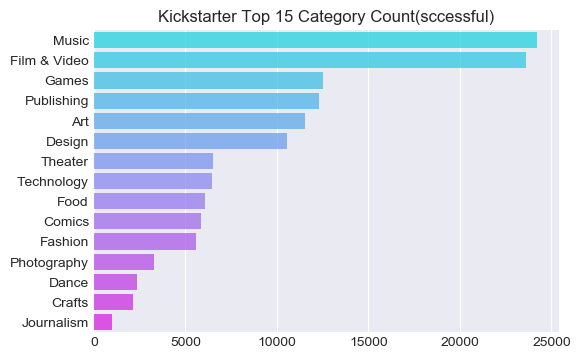

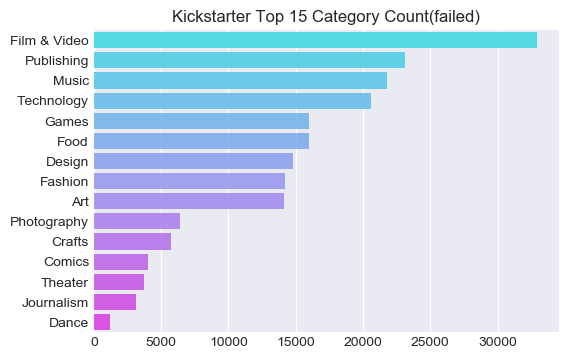

In [53]:
sns.set_style('darkgrid')
mains = df_kick.main_category.value_counts().head(15)

x = mains.values
y = mains.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="cool", alpha=0.8)

plt.title('Kickstarter Top 15 Category Count')
plt.show()

mains = df_kick[df_kick.state=='successful'].main_category.value_counts().head(15)

x = mains.values
y = mains.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="cool", alpha=0.8)

plt.title('Kickstarter Top 15 Category Count(sccessful)')
plt.show()

mains = df_kick[df_kick.state=='failed'].main_category.value_counts().head(15)

x = mains.values
y = mains.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="cool", alpha=0.8)

plt.title('Kickstarter Top 15 Category Count(failed)')
plt.show()

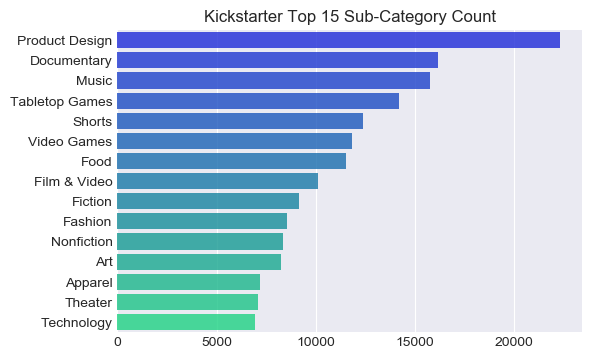

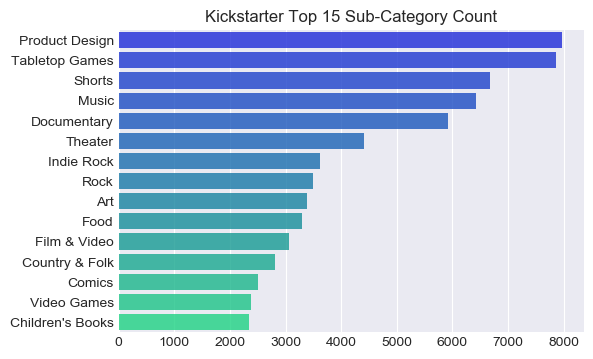

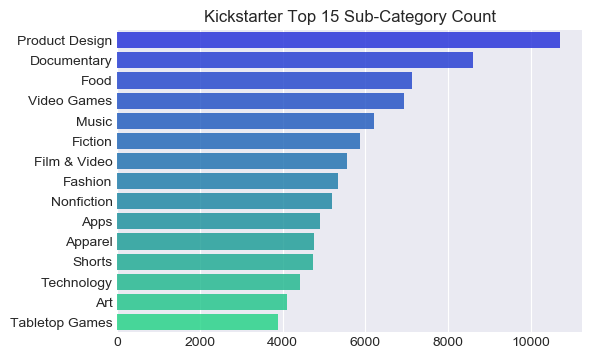

In [50]:
cats = df_kick.category.value_counts().head(15)

x = cats.values
y = cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="winter", alpha=0.8)

plt.title('Kickstarter Top 15 Sub-Category Count')
plt.show()

cats = df_kick[df_kick.state=='successful'].category.value_counts().head(15)

x = cats.values
y = cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="winter", alpha=0.8)

plt.title('Kickstarter Top 15 Sub-Category Count(successful)')
plt.show()

cats = df_kick[df_kick.state=='failed'].category.value_counts().head(15)

x = cats.values
y = cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="winter", alpha=0.8)

plt.title('Kickstarter Top 15 Sub-Category Count(failed)')
plt.show()

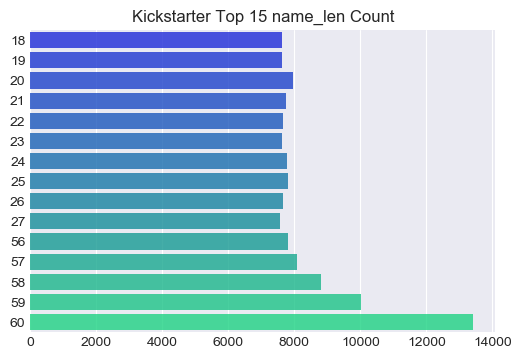

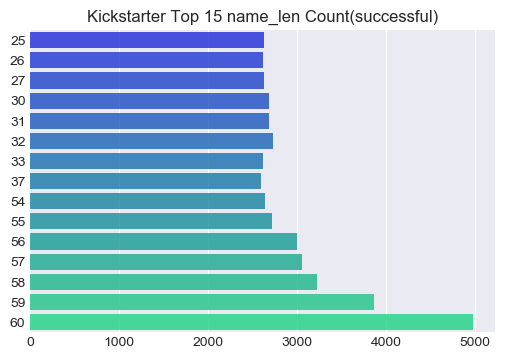

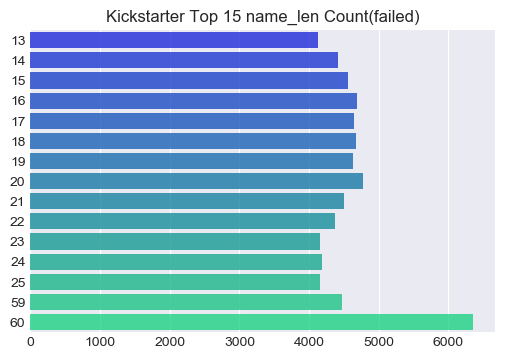

In [51]:
cats = df_kick.name_len.value_counts().head(15)

x = cats.values
y = cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="winter", alpha=0.8)

plt.title('Kickstarter Top 15 name_len Count')
plt.show()

cats = df_kick[df_kick.state=='successful'].name_len.value_counts().head(15)

x = cats.values
y = cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="winter", alpha=0.8)

plt.title('Kickstarter Top 15 name_len Count(successful)')
plt.show()

cats = df_kick[df_kick.state=='failed'].name_len.value_counts().head(15)

x = cats.values
y = cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="winter", alpha=0.8)

plt.title('Kickstarter Top 15 name_len Count(failed)')
plt.show()

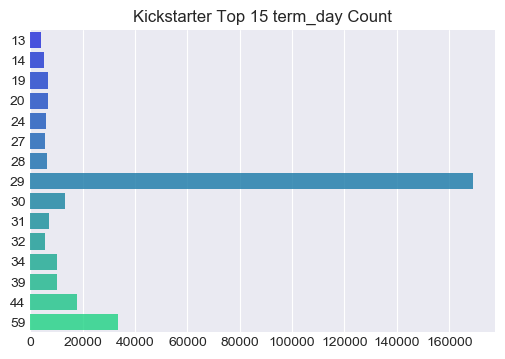

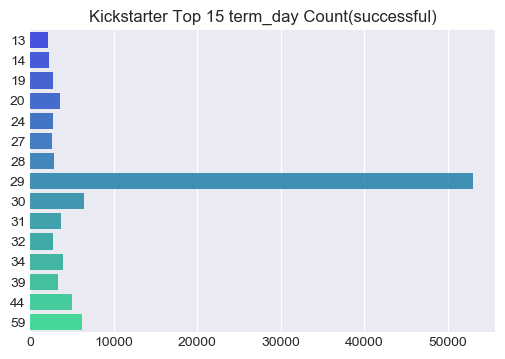

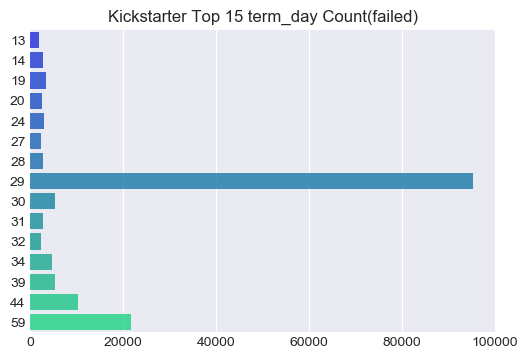

In [52]:
cats = df_kick.term_day.value_counts().head(15)

x = cats.values
y = cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="winter", alpha=0.8)

plt.title('Kickstarter Top 15 term_day Count')
plt.show()

cats = df_kick[df_kick.state=='successful'].term_day.value_counts().head(15)

x = cats.values
y = cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="winter", alpha=0.8)

plt.title('Kickstarter Top 15 term_day Count(successful)')
plt.show()

cats = df_kick[df_kick.state=='failed'].term_day.value_counts().head(15)

x = cats.values
y = cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="winter", alpha=0.8)

plt.title('Kickstarter Top 15 term_day Count(failed)')
plt.show()

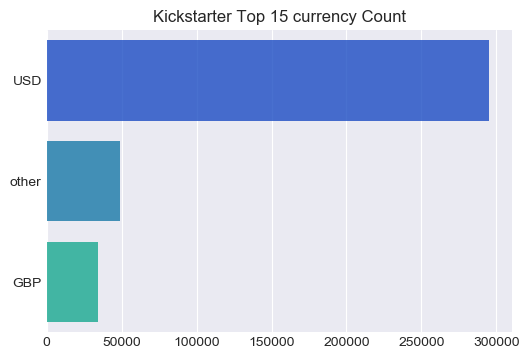

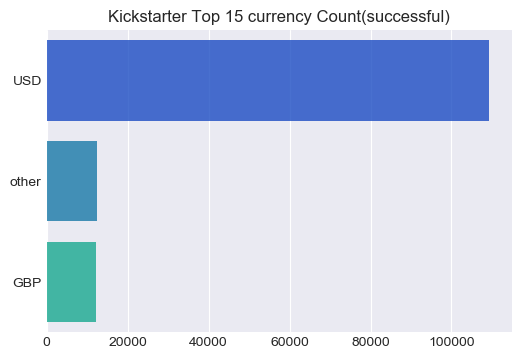

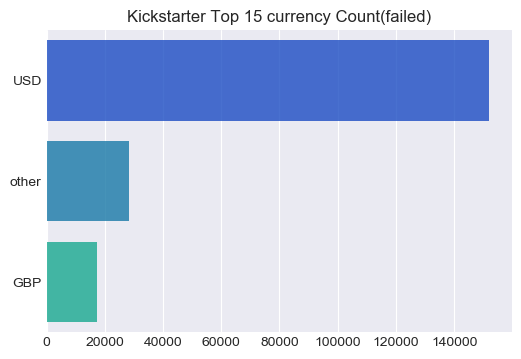

In [55]:
cats = df_kick.currency.value_counts().head(15)

x = cats.values
y = cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="winter", alpha=0.8)

plt.title('Kickstarter Top 15 currency Count')
plt.show()

cats = df_kick[df_kick.state=='successful'].currency.value_counts().head(15)

x = cats.values
y = cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="winter", alpha=0.8)

plt.title('Kickstarter Top 15 currency Count(successful)')
plt.show()

cats = df_kick[df_kick.state=='failed'].currency.value_counts().head(15)

x = cats.values
y = cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="winter", alpha=0.8)

plt.title('Kickstarter Top 15 currency Count(failed)')
plt.show()

In [ ]:
cats = df_kick.currency.value_counts().head(15)

x = cats.values
y = cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="winter", alpha=0.8)

plt.title('Kickstarter Top 15 currency Count')
plt.show()

cats = df_kick[df_kick.state=='successful'].currency.value_counts().head(15)

x = cats.values
y = cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="winter", alpha=0.8)

plt.title('Kickstarter Top 15 currency Count(successful)')
plt.show()

cats = df_kick[df_kick.state=='failed'].currency.value_counts().head(15)

x = cats.values
y = cats.index

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="winter", alpha=0.8)

plt.title('Kickstarter Top 15 currency Count(failed)')
plt.show()

In [16]:
(df_kick.deadline-df_kick.launched).dt.days.value_counts().head(15)

29    169171
59     33623
44     17749
30     13261
34     10099
39     10039
31      7294
19      6831
20      6716
28      6192
24      6139
32      5775
27      5466
14      5379
13      4176
dtype: int64

In [17]:
#df_kick['log_usd_per_backer'] = np.log(df_kick['usd pledged']/df_kick['backers'])
#df_kick['log_goal_per_backer'] = np.log(df_kick['goal']/df_kick['backers'])

C:\Users\oanc2fs1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [26]:
#backersに0が入っている行　かつ　stateがsuccessfulの行を確認
#df_kick[(df_kick.backers==0)&(df_kick.state=='successful')]
df_kick[(df_kick.backers==0)&(df_kick.state==True)]


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,country,usd pledged,usd_pledged_real,usd_goal_real,GBP,USD,other,term,term_day,name_len
2457,1012744036,An Oratorio for our Time - Last Stop Cafe,Music,Music,USD,2016-05-26,5000.0,2016-04-26 19:46:26,5170.00,True,...,"N,0""",NaN,5170.00,5000.00,0,1,0,29 days 04:13:34,29,41
4892,1024989802,Jackson Ruby: The Cassette Album,Music,Music,USD,2016-05-11,5000.0,2016-04-11 19:29:17,5296.00,True,...,"N,0""",NaN,5296.00,5000.00,0,1,0,29 days 04:30:43,29,32
5353,1027275369,Help Parker Brown make his first solo album,Music,Music,USD,2016-05-21,3800.0,2016-04-21 16:14:28,5077.00,True,...,"N,0""",NaN,5077.00,3800.00,0,1,0,29 days 07:45:32,29,43
5597,1028691308,Help BETHANY record a NEW single in Nash!,Music,Music,USD,2016-05-08,3500.0,2016-04-04 23:32:00,3502.13,True,...,"N,0""",NaN,3502.13,3500.00,0,1,0,33 days 00:28:00,33,41
8260,1041708793,Serena Gabriel's first CD!!!!!!: Diving Deep,Music,Music,USD,2016-05-01,3500.0,2016-03-25 17:20:21,3787.00,True,...,"N,0""",NaN,3787.00,3500.00,0,1,0,36 days 06:39:39,36,44
13001,1065249597,SCiO: Your Sixth Sense. A Pocket Molecular Sen...,Hardware,Technology,USD,2014-06-15,200000.0,2014-04-29 17:18:03,2762571.78,True,...,"N,0""",NaN,2762571.78,200000.00,0,1,0,46 days 06:41:57,46,59
13048,1065509232,LUME Festival 2016,Music,Music,GBP,2016-05-12,3500.0,2016-04-11 12:42:02,3606.00,True,...,"N,0""",NaN,5195.74,5043.01,1,0,0,30 days 11:17:58,30,18
14527,1073104639,SUNN - EP - Pre-vente,Music,Music,other,2016-05-04,4000.0,2016-03-25 16:56:43,4051.00,True,...,"N,0""",NaN,3145.43,3105.83,0,0,1,39 days 07:03:17,39,21
16769,1084993156,"Willy Tea, Chris Doud and Chums: The Children'...",Music,Music,USD,2013-04-09,3750.0,2013-03-26 05:06:11,4593.00,True,...,"N,0""",NaN,4593.00,3750.00,0,1,0,13 days 18:53:49,13,53
21385,110837091,Nathan Menard,Music,Music,USD,2016-05-07,8000.0,2016-03-28 20:38:22,8263.45,True,...,"N,0""",NaN,8263.45,8000.00,0,1,0,39 days 03:21:38,39,13


In [27]:
#0が入っている行のstateを確認
df_kick[(df_kick.backers==0)].state.value_counts()

False    55504
True       105
Name: state, dtype: int64

In [29]:
#df_kick_v2 = df_kick[(df_kick.backers!=0)|(df_kick.state!='successful')]
df_kick_v2 = df_kick[(df_kick.backers!=0)|(df_kick.state!=True)]


In [30]:
#0が入っている行のstateを確認
df_kick_v2[(df_kick_v2.backers==0)].state.value_counts()

False    55504
Name: state, dtype: int64

In [33]:
df_kick.state.value_counts()

False    244705
True     133956
Name: state, dtype: int64

In [34]:
df_kick_v2.state.value_counts()

False    244705
True     133851
Name: state, dtype: int64

In [39]:
 df_kick[(df_kick.state==True)].name_len.value_counts().head(10)

60    4976
59    3857
58    3222
57    3056
56    2997
32    2722
55    2714
30    2680
31    2676
54    2632
Name: name_len, dtype: int64

In [40]:
 df_kick[(df_kick.state==False)].name_len.value_counts().head(10)

60    8444
59    6158
58    5590
20    5535
19    5351
18    5299
21    5268
17    5227
22    5207
16    5195
Name: name_len, dtype: int64

In [68]:
cats_succ = df_kick[(df_kick.state=='successful')].category.value_counts()
cats_fail = df_kick[(df_kick.state=='failed')].category.value_counts()
#カテゴリ毎の成功割合で新しい列（category_succ_rate）を追加
def f_str(x):
    if type(x) is str:
        return cats_succ[x]/(cats_succ[x]+cats_fail[x])
    else:
        return 0
df_kick["category_succ_rate"] = df_kick.category.map(f_str)

cats_succ = df_kick[(df_kick.state=='successful')].main_category.value_counts()
cats_fail = df_kick[(df_kick.state=='failed')].main_category.value_counts()
#カテゴリ毎の成功割合で新しい列（category_succ_rate）を追加
def f_str(x):
    if type(x) is str:
        return cats_succ[x]/(cats_succ[x]+cats_fail[x])
    else:
        return 0
df_kick["main_category_succ_rate"] = df_kick.main_category.map(f_str)

In [65]:
cats_succ = df_kick[(df_kick.state=='successful')].category.value_counts()
cats_fail = df_kick[(df_kick.state=='failed')].category.value_counts()
print(cats_succ['Music']/(cats_succ['Music']+cats_fail['Music']))

0.5091427214438375


In [70]:
display(df_kick[df_kick.category=='Music'])

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,usd_pledged_real,usd_goal_real,GBP,USD,other,term,term_day,name_len,category_succ_rate,main_category_succ_rate
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,...,1.00,5000.00,0,1,0,29 days 20:35:49,29,49,0.509143,0.526606
18,1000070642,Mike Corey's Darkness & Light Album,Music,Music,USD,2012-08-17,250.0,2012-08-02 14:11:32,250.00,successful,...,250.00,250.00,0,1,0,14 days 09:48:28,14,35,0.509143,0.526606
25,1000102741,Matt Cavenaugh & Jenny Powers make their 1st a...,Music,Music,USD,2011-01-06,10000.0,2010-12-07 23:16:50,15827.00,successful,...,15827.00,10000.00,0,1,0,29 days 00:43:10,29,52,0.509143,0.526606
34,100012079,Chris Eger Band - New Nashville Record!,Music,Music,USD,2014-08-13,12000.0,2014-07-14 22:35:51,13260.00,successful,...,13260.00,12000.00,0,1,0,29 days 01:24:09,29,39,0.509143,0.526606
41,1000153208,Phil Younger - Slow Down (Official Music Video),Music,Music,USD,2016-12-20,2100.0,2016-12-09 20:27:02,2100.00,successful,...,2100.00,2100.00,0,1,0,10 days 03:32:58,10,47,0.509143,0.526606
89,1000344383,¿Tu Sabes? (You Know?) a music collaboration b...,Music,Music,USD,2012-12-13,4500.0,2012-10-30 08:53:03,409.00,failed,...,409.00,4500.00,0,1,0,43 days 15:06:57,43,58,0.509143,0.526606
160,100065084,One Man's Opinion Of Moonlight Song Collection,Music,Music,USD,2017-06-29,1450.0,2017-06-14 19:57:18,1647.00,successful,...,1647.00,1450.00,0,1,0,14 days 04:02:42,14,46,0.509143,0.526606
172,1000707541,Elephant Gun Media Blitzkrieg,Music,Music,USD,2011-11-04,777.0,2011-10-20 23:51:42,923.00,successful,...,923.00,777.00,0,1,0,14 days 00:08:18,14,29,0.509143,0.526606
182,1000758916,Keys to the Moon's First Full Length Album!,Music,Music,USD,2016-10-01,4000.0,2016-09-01 15:32:07,4629.00,successful,...,4629.00,4000.00,0,1,0,29 days 08:27:53,29,43,0.509143,0.526606
294,1001303993,A Jessica Rabbit Production,Music,Music,USD,2012-07-16,1300.0,2012-06-28 05:56:40,625.00,failed,...,625.00,1300.00,0,1,0,17 days 18:03:20,17,27,0.509143,0.526606


In [72]:
cats_succ = df_kick[(df_kick.state=='successful')].main_category.value_counts()
cats_fail = df_kick[(df_kick.state=='failed')].main_category.value_counts()
print(cats_succ['Music']/(cats_succ['Music']+cats_fail['Music']))

0.5266055844523276


In [73]:
display(df_kick.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,usd_pledged_real,usd_goal_real,GBP,USD,other,term,term_day,name_len,category_succ_rate,main_category_succ_rate
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,0.0,1533.95,1,0,0,58 days 11:47:32,58,31,0.390851,0.347017
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,2421.0,30000.00,0,1,0,59 days 19:16:03,59,45,0.435903,0.417906
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,220.0,45000.00,0,1,0,44 days 23:39:10,44,14,0.435903,0.417906
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,1.0,5000.00,0,1,0,29 days 20:35:49,29,49,0.509143,0.526606
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,...,1283.0,19500.00,0,1,0,55 days 15:24:57,55,58,0.355983,0.417906
